In [7]:
# import related model and define functions for visualization
import torch
import numpy as np 
from segment_anything import sam_model_registry, sam_model_registry_baseline, SamPredictor
import os
import matplotlib.pyplot as plt 
import cv2
import torch.nn.functional as F
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_res_multi(masks, scores, input_point, input_label, input_box, filename, image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    for box in input_box:
        show_box(box, plt.gca())
    for score in scores:
        print(f"Score: {score:.3f}")
    plt.axis('off')
    plt.savefig(filename +'.png',bbox_inches='tight',pad_inches=-0.1)
    plt.close()


def downsample_sam_feature(feature):
    feature_max_dim = np.max(feature.shape[1:])
    padded_feature = np.pad(feature, ((0, 0), (0, feature_max_dim - feature.shape[1]), 
                                      (0, feature_max_dim - feature.shape[2])), mode='constant')
    
    target_res = 64
    factor = feature_max_dim // target_res
    offset = factor // 2 - 1

    downsampled_feature = padded_feature[:, offset::factor, offset::factor]

    return downsampled_feature


In [6]:
root_dir = '/disk1/yichen/lerf'

model_type = "default"
sam_checkpoint = '/disk1/yichen/sam_vit_h_4b8939.pth'
device = 'cuda:0'


image_file = os.path.join(root_dir, 'debug/featuremap.png')
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
sam_feature = np.load(os.path.join(root_dir, 'debug/featuremap.npy'))
sam_feature = sam_feature.transpose(2,0,1)

contrastive_feature = np.load(os.path.join(root_dir, 'debug/featuremap_ctr.npy'))
contrastive_feature = contrastive_feature.transpose(2,0,1)

hqsam_feature = []
for i in range(4):
    hqsam_feature.append(np.load(os.path.join(root_dir, f'debug/featuremap_hq{i}.npy')).transpose(2,0,1))

input_point = np.array([[400, 100]])
input_label = np.array([1])
input_box = None


[ WARN:0@969.828] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/disk1/yichen/lerf/debug/featuremap.png'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [8]:
# load related features(code for lyc)

root_dir = '/ssddata/yliugu/lerf'

model_type = "vit_l"
sam_checkpoint = os.path.join(root_dir, 'dependencies/sam-hq/pretrained_checkpoint/sam_hq_vit_l.pth')
device = 'cuda:0'


image_file = os.path.join(root_dir, 'debug/featuremap.png')
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
sam_feature = np.load(os.path.join(root_dir, 'debug/featuremap.npy'))
sam_feature = sam_feature.transpose(2,0,1)
print(sam_feature.shape)

contrastive_feature = np.load(os.path.join(root_dir, 'debug/featuremap_ctr.npy'))
contrastive_feature = contrastive_feature.transpose(2,0,1)

hqsam_feature = []
for i in range(4):
    hqsam_feature.append(np.load(os.path.join(root_dir, f'debug/featuremap_hq{i}.npy')).transpose(2,0,1))

input_point = np.array([[180, 300]])
input_label = np.array([1])
input_box = None

(256, 320, 512)


<All keys matched successfully>


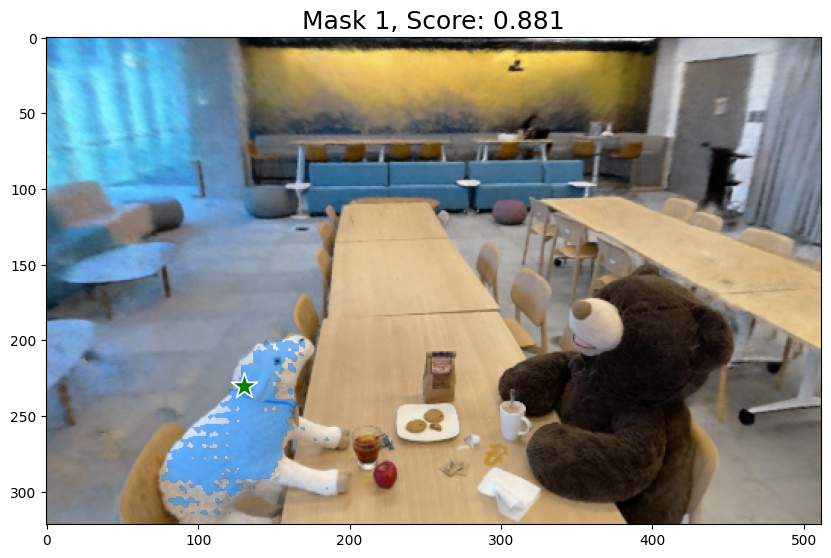

In [49]:
# HQ-SAM demo code
sam = sam_model_registry_baseline[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
hq_token_only = False 
# To achieve best visualization effect, for images contain multiple objects (like typical coco images), we suggest to set hq_token_only=False
# For images contain single object, we suggest to set hq_token_only = True
# For quantiative evaluation on COCO/YTVOS/DAVIS/UVO/LVIS etc., we set hq_token_only = False
predictor.set_image(image)


downsampled_sam_feature = downsample_sam_feature(sam_feature)
predictor.features = torch.from_numpy(downsampled_sam_feature).to(predictor.device)[None, ...]

for i in range(len(hqsam_feature)):
    cur_interm = downsample_sam_feature(hqsam_feature[i])
    predictor.interm_features[i] = torch.from_numpy(cur_interm).to(predictor.device).permute(1,2,0)[None, ...]
# print(predictor.features.shape)
# print(predictor.interm_features[0].shape)
# predictor.set_feature

masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            box = input_box,
            multimask_output=False,
            hq_token_only=hq_token_only, 
            return_logits=False
        )

# masks = masks.squeeze(1).cpu().numpy()
# scores = scores.squeeze(1).cpu().numpy()
# input_box = input_box.cpu().numpy()

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    
    # plt.imshow(mask, cmap='rainbow')
    # show_points(input_point, input_label, plt.gca())
    
    plt.axis('on')

<All keys matched successfully>


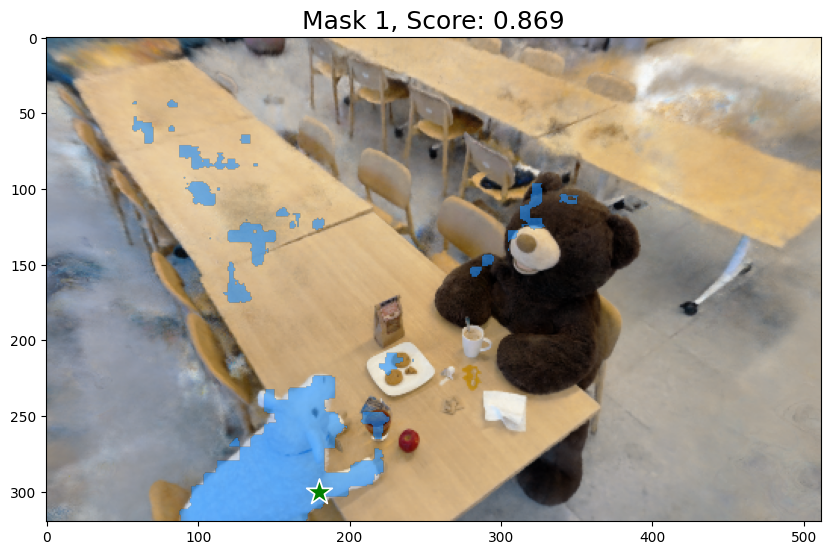

In [9]:
# SAM demo code

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
hq_token_only = False 
# To achieve best visualization effect, for images contain multiple objects (like typical coco images), we suggest to set hq_token_only=False
# For images contain single object, we suggest to set hq_token_only = True
# For quantiative evaluation on COCO/YTVOS/DAVIS/UVO/LVIS etc., we set hq_token_only = False
predictor.set_image(image)


downsampled_sam_feature = downsample_sam_feature(sam_feature)
predictor.features = torch.from_numpy(downsampled_sam_feature).to(predictor.device)[None, ...]

# print(predictor.features.shape)
# print(predictor.interm_features[0].shape)
# predictor.set_feature

masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            box = input_box,
            multimask_output=False,
            return_logits=False
        )
# masks = masks.squeeze(1).cpu().numpy()
# scores = scores.squeeze(1).cpu().numpy()
# input_box = input_box.cpu().numpy()

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    # plt.imshow(mask, cmap='rainbow')
    # show_points(input_point, input_label, plt.gca())
    plt.axis('on')

torch.Size([155136, 256])
torch.Size([256])
torch.Size([155136])


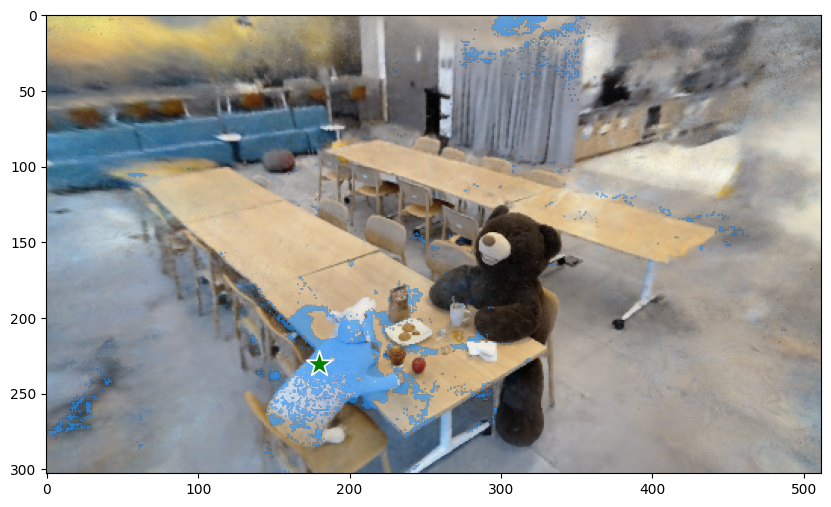

In [25]:
def similar_func(feature_q, support):
    similar_type = 'l2_exp'
    if similar_type == 'cos':
        feature_q = feature_q / feature_q.norm(dim=-1, keepdim=True)
        support = support / support.norm(dim=-1, keepdim=True)
        pred_1 = F.cosine_similarity(feature_q, support, dim=1)
    elif similar_type == 'l2':
        pred_1 = torch.sum((feature_q - support)**2, dim=-1)
        pred_1 = torch.pow(pred_1, 0.5) / feature_q.norm(dim=-1, keepdim=False)
    elif similar_type == 'l2_exp':
        print(torch.sum((feature_q - support)**2, -1).shape)
        pred_1 = torch.exp(-torch.sum((feature_q - support)**2, -1))
    return pred_1



with torch.no_grad():
    sam_feature_dim = contrastive_feature.shape
    flatten_feature = contrastive_feature.reshape([sam_feature_dim[0], -1])
    flatten_feature = torch.from_numpy(flatten_feature)
    flatten_feature = flatten_feature.permute(1,0)
    flatten_feature = flatten_feature
    flatten_feature_norm = flatten_feature.norm(dim=-1, keepdim=False)


    support_ray_index = input_point[0][0] + input_point[0][1] * sam_feature_dim[2]
    # support_ray_index = torch.randint(0,  flatten_feature.size(0), (1,))
    support_ray = flatten_feature[support_ray_index]

    # self_support_mask = self_support(flatten_feature, support_ray)
    # self_support_mask = F.cosine_similarity(flatten_feature, support_ray, dim=1)

    print(flatten_feature.shape)
    print(support_ray.shape)
    self_support_mask = similar_func(flatten_feature, support_ray)
    
    self_support_mask = self_support_mask.reshape(sam_feature_dim[1:])
    self_support_mask = (self_support_mask > 0.6)
    
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(self_support_mask, plt.gca())
    show_points(input_point, input_label, plt.gca())

In [23]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

(256, 64, 64)
16.559353
-28.485193
torch.Size([65, 60, 256])
torch.Size([3900])
torch.Size([65, 61, 256])
torch.Size([3965])
torch.Size([64, 60, 256])
torch.Size([3840])
torch.Size([64, 61, 256])
torch.Size([3904])


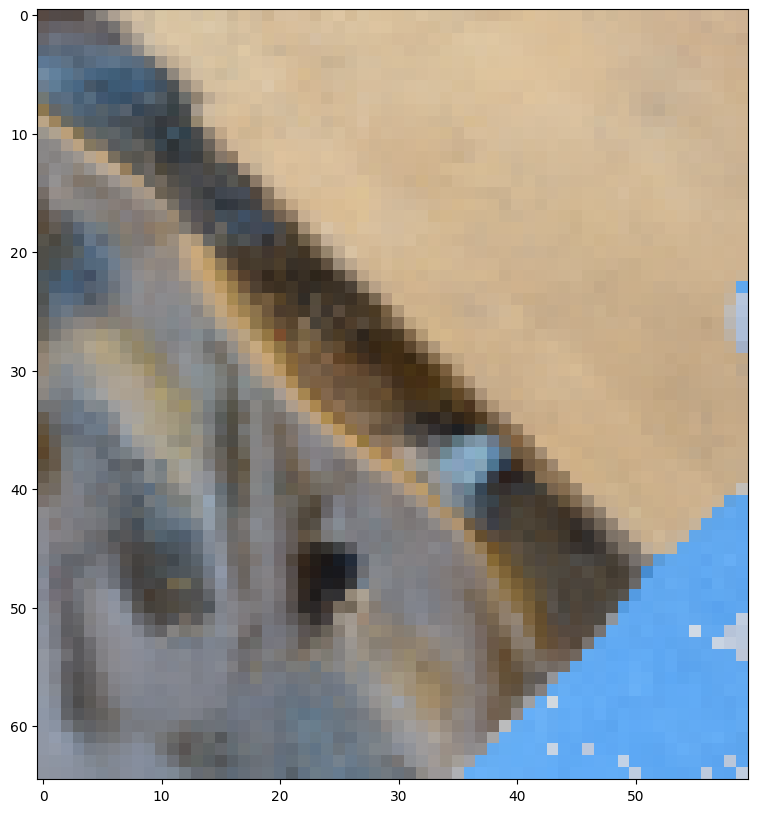

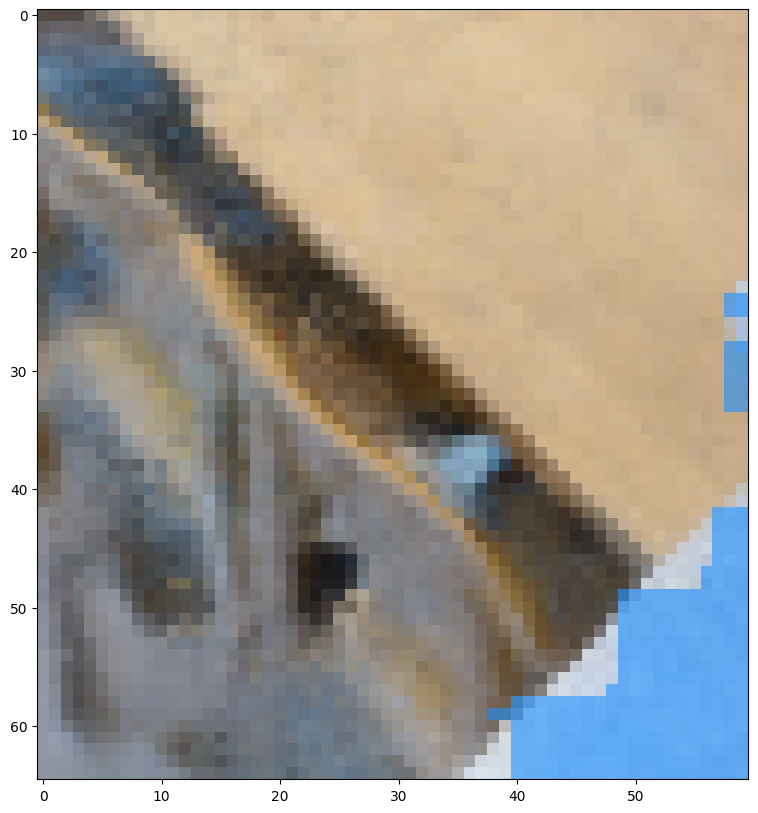

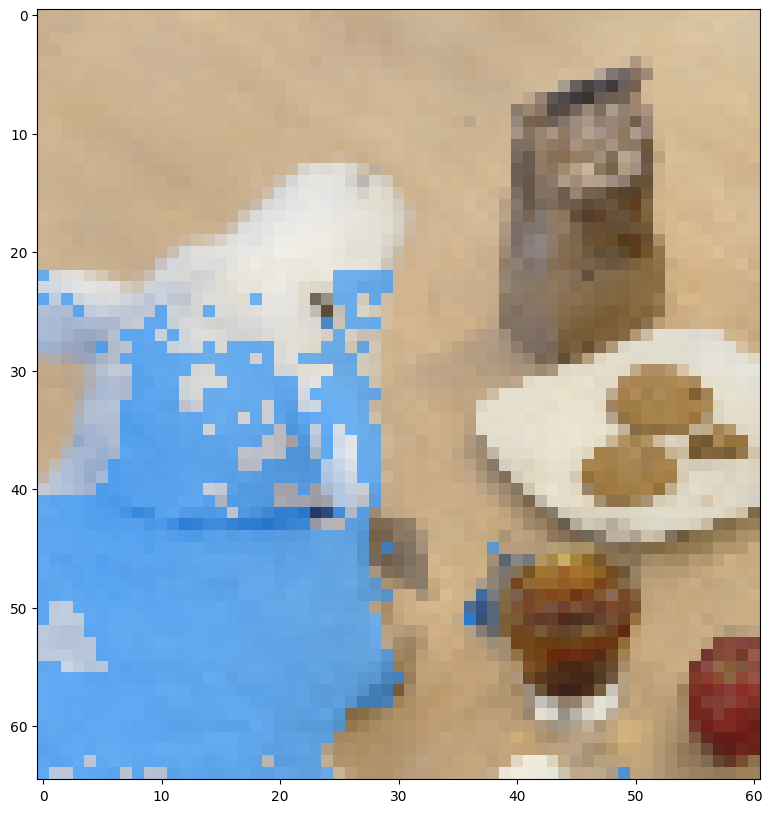

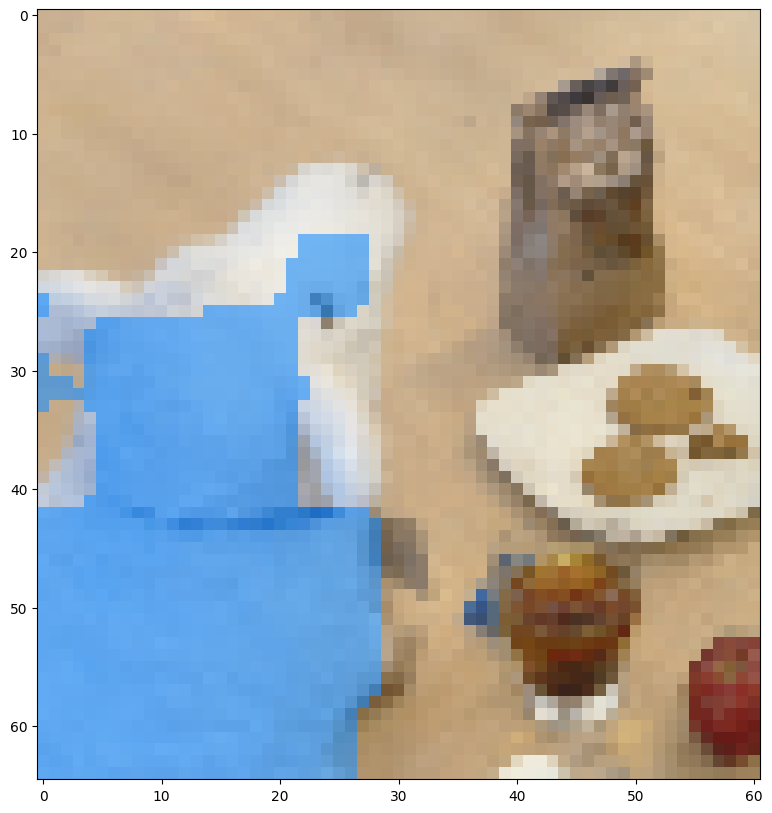

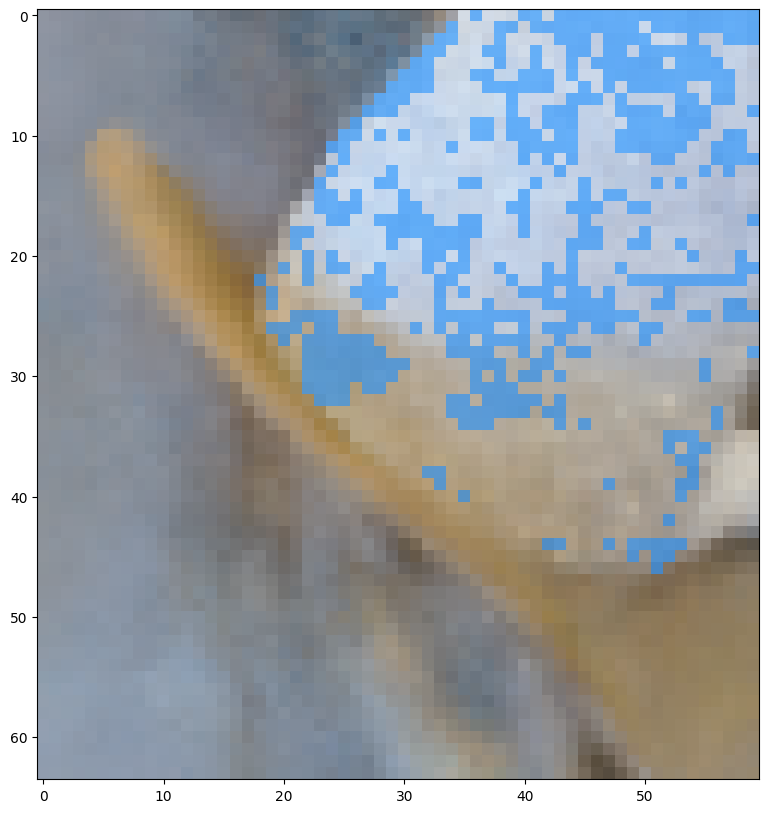

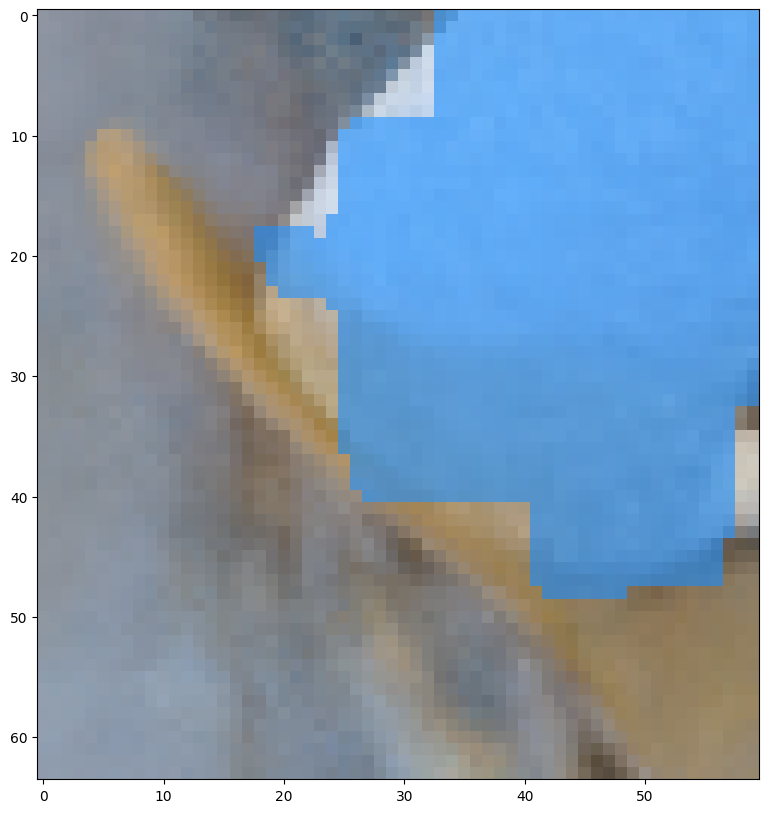

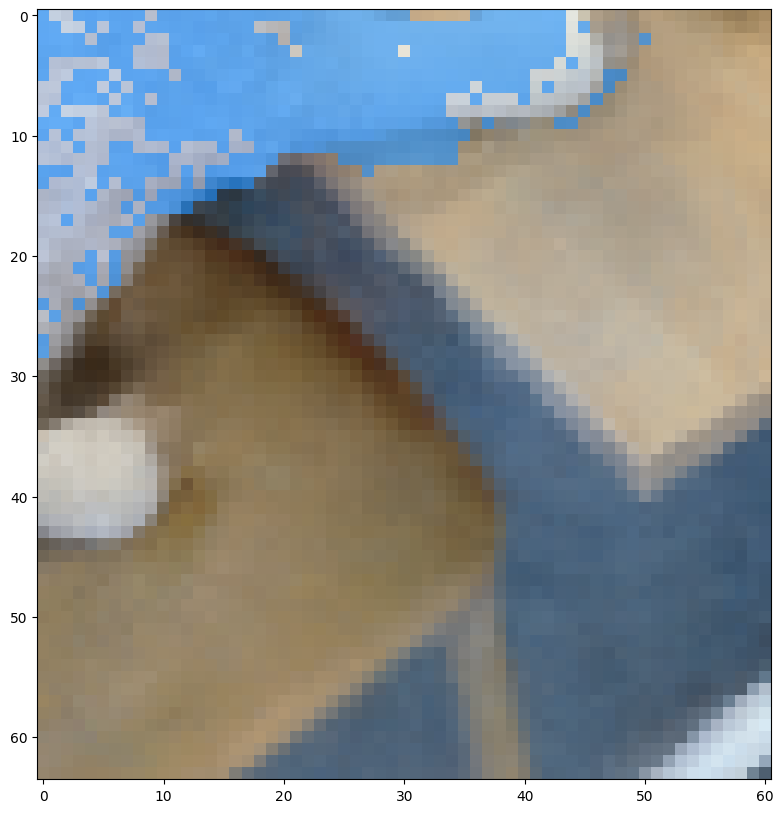

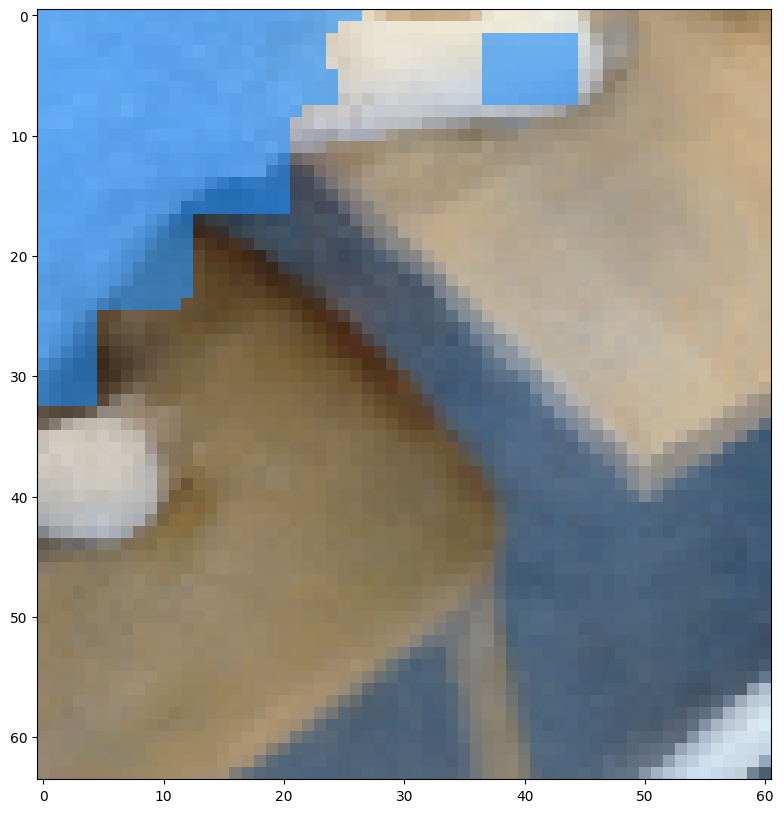

In [27]:


def decode_multi_scale(predictor, image, contrastive_feature, sam_feature=None):
    patch_scale = 2
    predictor.set_image(image)
    if sam_feature is not None:
        downsampled_feature = downsample_sam_feature(sam_feature)
        torch_feature = torch.from_numpy(downsampled_feature).float().to(device)
        torch_feature = torch_feature.unsqueeze(0)
        predictor.features = torch_feature

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    print(logits.max())
    print(logits.min())
    masks, scores = torch.from_numpy(masks), torch.from_numpy(scores)
    idx = torch.argmax(scores)
    contrastive_feature = torch.from_numpy(contrastive_feature)
    
    
    support_ray = contrastive_feature[:, input_point[0][1], input_point[0][0]]
    
    
    crop_img, crop_mask, crop_feat = crop(image, contrastive_feature.permute(1,2,0), masks[idx])
    # crop_img, crop_mask, crop_feat = torch.from_numpy(crop_img), torch.from_numpy(crop_mask), torch.from_numpy(crop_feat)
    crop_shape = crop_mask.shape
    y_coord = torch.linspace(0, crop_shape[0], patch_scale+1)
    x_coord = torch.linspace(0, crop_shape[1], patch_scale+1)

    for i in range(y_coord.size(0)-1):
        for j in range(x_coord.size(0)-1):
            y_start, y_end= torch.ceil(y_coord[i]).to(torch.int64), torch.ceil(y_coord[i+1]).to(torch.int64)
            x_start, x_end = torch.floor(x_coord[j]).to(torch.int64), torch.floor(x_coord[j+1]).to(torch.int64)

            patch_feat = crop_feat[y_start:y_end, x_start:x_end]
            patch_mask = crop_mask[y_start:y_end, x_start:x_end]
            patch_img = crop_img[y_start:y_end, x_start:x_end]
            print(patch_feat.shape)
            patch_shape = patch_feat.shape

            patch_feat_flatten = patch_feat.reshape(-1, patch_feat.shape[-1])
            
            patch_mask_flatten = patch_mask.reshape(-1)
            
            patch_support_ray = patch_feat_flatten[patch_mask_flatten].mean(0)
            
            patch_support_ray = patch_support_ray * 0.5 + support_ray * 0.5
            patch_similar_map = similar_func(patch_feat_flatten, patch_support_ray)

            patch_similar_map = patch_similar_map.reshape(patch_shape[:2])
            patch_similar_mask = (patch_similar_map > 0.8)

            plt.figure(figsize=(10,10))
            plt.imshow(patch_img)
            show_mask(patch_similar_mask, plt.gca())
            plt.figure(figsize=(10,10))
            plt.imshow(patch_img)
            show_mask(patch_mask, plt.gca())          
            

    
    
def crop(image, contrastive_feature, mask):
    enlarge_scale = 0.2
    mask_shape = mask.shape
    
    coord = torch.nonzero(mask)
    y_min, y_max = coord[:,0].min(), coord[:,0].max()
    x_min, x_max = coord[:,1].min(), coord[:,1].max()
    y_scale = (y_max - y_min) * enlarge_scale
    x_scale = (x_max - x_min) * enlarge_scale
    
    y_min = torch.clamp(y_min - y_scale, min=0).to(torch.int64)
    y_max = torch.clamp(y_max + y_scale, max=mask_shape[0]).to(torch.int64)
    x_min = torch.clamp(x_min - x_scale, min=0).to(torch.int64)
    x_max = torch.clamp(x_max + x_scale, max=mask_shape[1]).to(torch.int64)
    
    return image[y_min:y_max, x_min:x_max], mask[y_min:y_max, x_min:x_max], contrastive_feature[y_min:y_max, x_min:x_max]

decode_multi_scale(predictor, image,contrastive_feature, sam_feature)


(1, 256, 256)


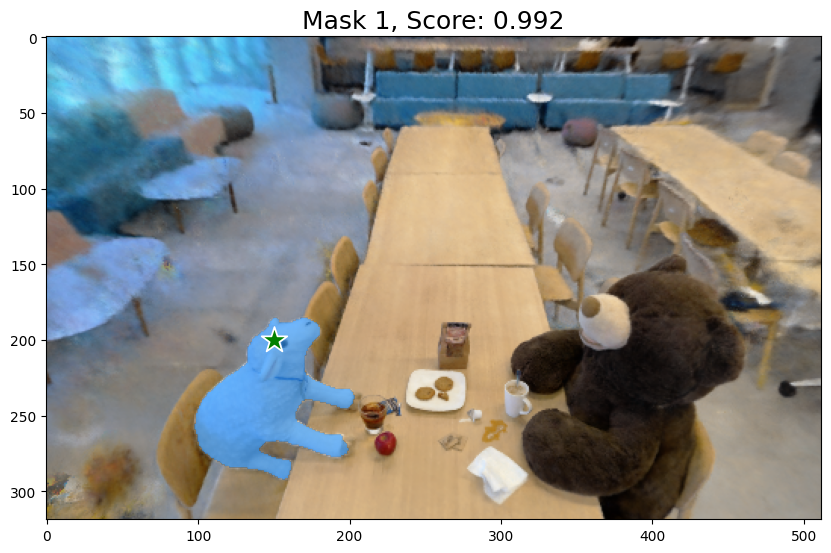

In [4]:
predictor.set_image(image)

# downsampled_feature = downsample_sam_feature(sam_feature)
# torch_feature = torch.from_numpy(downsampled_feature).float().to(device)
# torch_feature = torch_feature.unsqueeze(0)
# predictor.features = torch_feature
# predictor.set_torch_feature(sam_feature)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
print(logits.shape)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('on')